# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [13]:
cor_sat = combined.corr()
cor_sat = cor_sat['sat_score'][survey_fields]
cor_sat

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

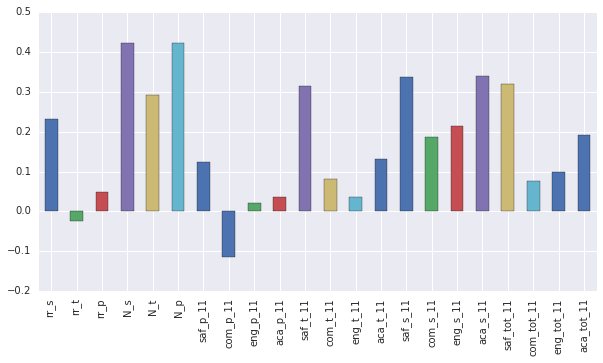

In [14]:
import seaborn as sns
plt.figure(figsize=(10, 5))
cor_sat.plot(kind='bar')
plt.show()


The strongest positive correlation was observed between the total number of student respondants and the sat_score.

The response rate from teachers and the communication skills based on parents responses show a weak negative correlation.

There were interesting correlations in different survey fields, such as safety score from the teachers, number of student and parent respondants, and the response rate from students. These all show positive correlations which we might find interesting to look into, with safety rates being the highest among them.

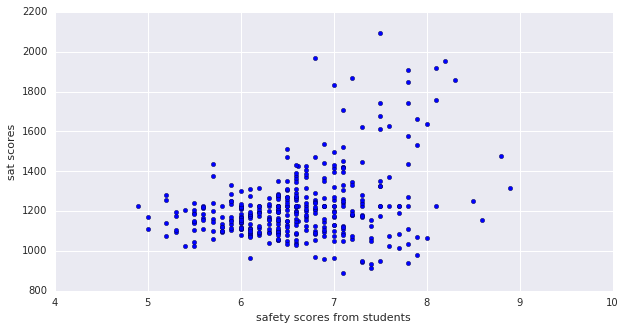

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(x=combined['saf_s_11'], y=combined['sat_score'])
plt.xlabel('safety scores from students')
plt.ylabel('sat scores')
plt.show()

From our scatterplot, we can see that most of the sat scores lie from safety scores of 5 to 7. 

In [16]:
combined['saf_s_11']

0      6.000000
1      6.000000
2      6.611667
3      6.400000
4      7.300000
5      8.300000
6      7.300000
7      6.200000
8      7.400000
9      7.100000
10     6.600000
11     6.500000
12     7.000000
13     6.000000
14     6.600000
15     6.800000
16     6.100000
17     7.800000
18     6.900000
19     6.200000
20     6.600000
21     7.100000
22     7.100000
23     7.800000
24     7.500000
25     7.100000
26     8.100000
27     7.500000
28     6.700000
29     6.500000
         ...   
333    5.900000
334    7.000000
335    7.100000
336    6.000000
337    5.500000
338    8.100000
339    7.300000
340    6.600000
341    5.600000
342    7.000000
343    6.500000
344    7.400000
345    6.800000
346    8.000000
347    6.900000
348    6.400000
349    6.700000
350    6.100000
351    5.200000
352    6.000000
353    7.100000
354    6.700000
355    6.000000
356    8.200000
357    5.800000
358    6.400000
359    6.500000
360    6.400000
361    8.900000
362    6.600000
Name: saf_s_11, Length: 

In [17]:
numpy.mean(combined['saf_s_11'])

6.611666666666666

Looks like the average safety score for each borogh in New York City is 6.6. 

From our research on safety by geographic area in NYC, we see that The Bronx and Manhattan has the most assault and robbery cases. Places like Brooklyn and Queens are relatively safe.

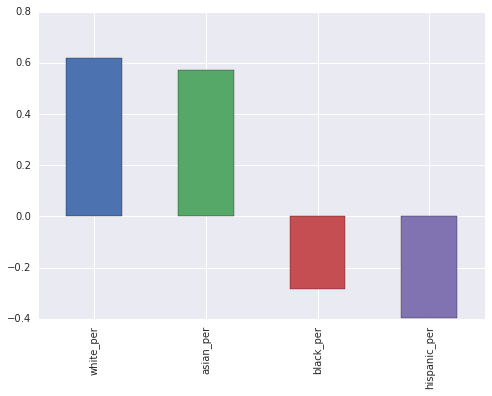

In [18]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

race_cor = combined.corr()['sat_score'][race_cols].plot(kind='bar')
race_cor
plt.show()

From this bar graph, we see that whites and asians do fairly well on the sat compared to hispanics and blacks.

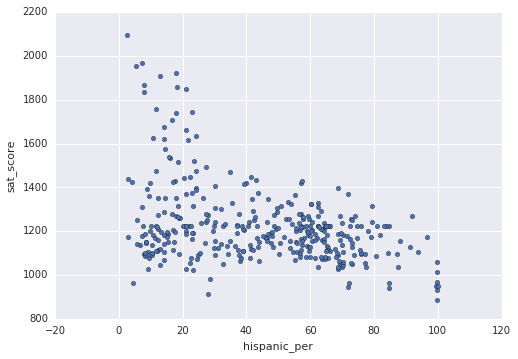

In [19]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')
plt.show()

This scatterplot shows that about 20-65 percent of the hispanic population in schools do fairly poorly on the sat.

It does show a fairly weak negative correlation between the two columns.

In [20]:
combined['SCHOOL NAME'][combined['hispanic_per'] > 95]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From the internet, we cac find that these schools accept immigrants and consist of a large number of spanish children.

In [21]:
combined['SCHOOL NAME'][(combined['hispanic_per'] < 10) & 
                        (combined['sat_score'] > 1800)]


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From this we can see the schools with low hispanic percentages are quite recognizable with notable alumni becoming renowned amongst the population.

In [22]:
gender_cor = combined.corr()
male_cor = gender_cor['sat_score']['male_per']
female_cor = gender_cor['sat_score']['female_per']

In [23]:
male_cor

-0.11206243686028577

In [24]:
female_cor

0.11210773942203284

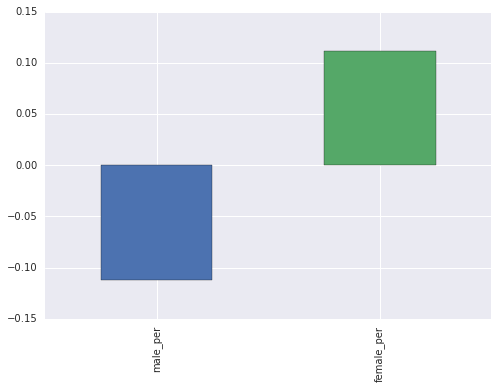

In [25]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot(
    kind='bar')
plt.show()

From this bar graph we can see that most of the male students do poorly on the sat whereas the female students do particlarly well.

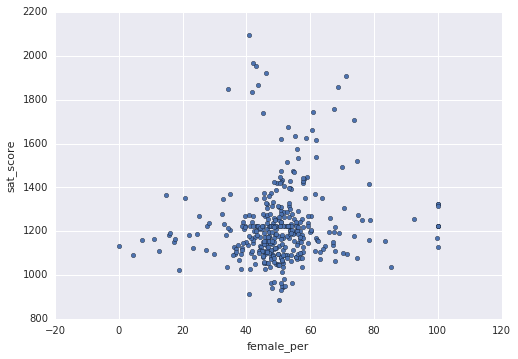

In [26]:
combined.plot(kind='scatter', x='female_per', y='sat_score')
plt.show()

This scatterplot shows that schools with about 40-65 percent of female students do fairly well on the sat.

In [27]:
combined['SCHOOL NAME'][
    (combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From the internet, we can see that these schools are acedemically focused with a large percentage of homework and schoolwork. Students are mostly comprised of women and they find fun in doing things like math and science.

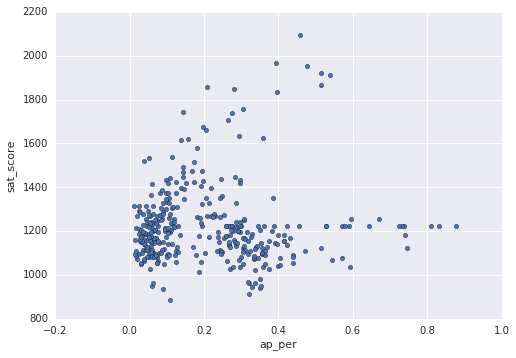

In [28]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

combined.plot(kind='scatter', x='ap_per', y='sat_score')
plt.show()



This scatteplot shows us that the percentage of students in each school who took an AP exam do fairly 'ok' on the sat with scores ranging from 1100 to 1400.